# Comparison between artifical language and natural language
## A comparison between PCFG generated data and the Penn Tree Bank data

In [25]:
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.patches as mpatches
import os
import string
import scipy.optimize as opt
import matplotlib.colors as mcolors
import random
from sklearn.metrics import r2_score
from mandelbrot import Mandelbrot

plt.rc('text', usetex = True)

In [24]:
PTB = []
sentences_results_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/PTB/penn-sentences.txt')
with open(sentences_results_path) as f:
	for i, sentence in enumerate(f.readlines()):
		PTB.append(sentence.split(' '))

In [9]:
AL = []
AL_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/corpora/eval.txt')
with open(AL_path) as f:
	for i, sentence in enumerate(f.readlines()):
		AL.append(sentence.split(' '))

## Length of sentences

In [173]:
def stats_dataset(dataset):
	print(
	f"""The length of the AL corpus is {len(dataset)}.
	The maximum length is {max(dataset)}. 
	The minimum length is {min(dataset)}.""")

In [174]:
lengthsAL = [len(i) for i in AL]
stats_dataset(lengthsAL)

The length of the AL corpus is 10000.
	The maximum length is 19. 
	The minimum length is 7.


In [62]:
# PTB
cutoff_max = 20
cutoff_min = 6
lengthsPTB = [len(i) for i in PTB if len(i) < cutoff_max and len(i) > cutoff_min]
stats_dataset(lengthsPTB)

The length of the AL corpus is 11406.
    The maximum length is 19. 
    The minimum length is 7.


In [184]:
def plot_length_dist(dataset, name):
	# plot smooth distribution of sentence lengths
	density = gaussian_kde(dataset)
	x = np.linspace(min(dataset), max(dataset), len(dataset))

	plt.hist(dataset, bins=10, density=True, alpha=0.7, label='Data')
	b_path = mpatches.Patch(edgecolor='#1F77B4', facecolor='#1F77B4', label=f'Data')
	plt.plot(x, density(x), color='#FF7F0E')
	plt.fill_between(x, density(x), alpha=0.5, color='#FF7F0E')
	o_patch = mpatches.Patch(edgecolor='#FF7F0E', facecolor='#FFBF86', label=f'Distribution')
	plt.xlabel('Sentence length')
	plt.title(f'Distribution of sentence lengths of {name}')
	
	ax = plt.gca()
	ax.spines[['right', 'top', 'left']].set_visible(False)
	ax.get_yaxis().set_visible(False)   
	plt.xlabel('Sentence length')
	plt.title(f'Distribution of Sentence Lengths of full PCFG Corpus')
	# plt.legend(handles=[o_patch, b_path])
	plt.tight_layout()

	plt.savefig(f'./plots/sentence-lengths-og.pdf')

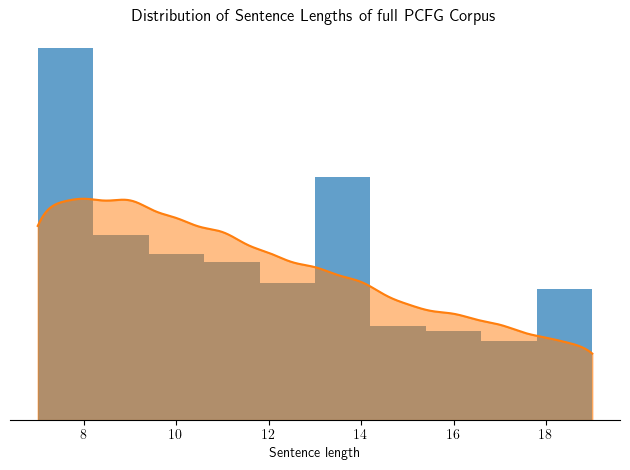

In [185]:
plot_length_dist(lengthsAL, 'AL')

In [66]:
def plot_comparison_dist(dataset1, dataset2, name1, name2):
	# plot smooth distribution of sentence lengths
	density1 = gaussian_kde(dataset1)
	density2 = gaussian_kde(dataset2)
	print(len(dataset1), len(dataset2))
	x1 = np.linspace(min(dataset1), max(dataset1), len(dataset1))
	x2 = np.linspace(min(dataset2), max(dataset2), len(dataset2))

	plt.plot(x1, density1(x1), color='#FF7F0E')
	plt.fill_between(x1, density1(x1), alpha=0.5, color='#FF7F0E')
	o_patch = mpatches.Patch(edgecolor='#FF7F0E', facecolor='#FFBF86', label=f'{name1}')

	plt.plot(x2, density2(x2), color='#1F77B4', label=f'Distr of {name2}')
	plt.fill_between(x2, density2(x2), alpha=0.5, color='#1F77B4')
	b_patch = mpatches.Patch(edgecolor='#1F77B4', facecolor='#8FBBD9', label=f'{name2}')

	ax = plt.gca()
	ax.spines[['right', 'top', 'left']].set_visible(False)
	ax.get_yaxis().set_visible(False)   
	plt.xlabel('Sentence length')
	plt.title(f'Distribution of sentence lengths of {name1} and {name2}')
	plt.legend(handles=[o_patch, b_patch])

11406 10000


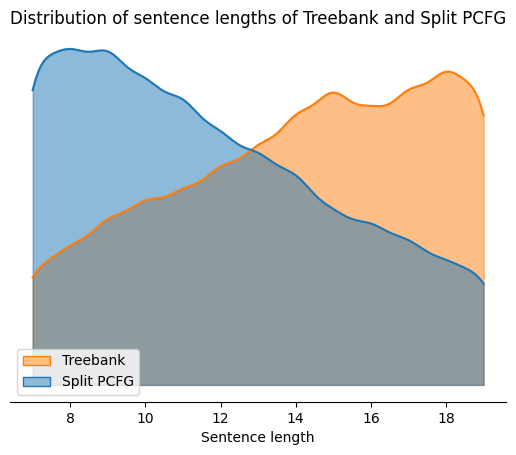

In [67]:
plot_comparison_dist(lengthsPTB, lengthsAL, 'Treebank', 'Split PCFG')

## Zipf curve

### Old zipf code

In [ ]:
# def create_vocab(data):
#     unwantedCharacters = list(string.punctuation)

#     vocab = defaultdict(int)
#     # Cleaning and counting the Text
#     for text in data:
#         for word in text:
#             # Remove unwanted characters from the texts
#             if word in unwantedCharacters:
#                 text.remove(word)
#                 continue

#             vocab[word] += 1

#     return vocab


# def zipf_equation(x, alpha, beta):
#     return 1/(x+beta)**alpha


# def Zipf_curve(data):
#     vocab = create_vocab(data)

#     freq = np.zeros(len(vocab.keys()))
#     rank = np.zeros(len(vocab.keys()))
#     for i, count in enumerate(vocab.values()):
#         sample = np.random.binomial(count, 0.5)
#         freq[i] = sample
#         rank[i] = count - sample
	
#     indices = np.argsort(rank)[::-1]
#     rank = np.sort(rank[::-1])
#     freq = freq[indices]
#     freq = freq / np.linalg.norm(freq)
#     x_values = np.arange(1, len(vocab.keys())+1)

#     # Fit Eq. 2 to the data
#     params, _ = opt.curve_fit(zipf_equation, x_values, freq, maxfev=10000)

#     # Generate fitted line
#     fitted_line = zipf_equation(x_values, *params)

#     return x_values, freq, fitted_line, params



# def plot_Zipf_curve_comparison(data1, data2, name1, name2):
# 	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
# 	data = [data1, data2]
# 	names = [name1, name2]

# 	# define color schema
# 	colors = ["blue", "lightgreen"]
# 	cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

	for i, ax in enumerate([ax1, ax2]):
		# get the distribution over the data and the Zipf curve
		# plot_zipf(data[i], title=f'{names[i]}', ax=ax)
		# x_values, y_values, fitted_line, params = Zipf_curve(data[i])

		# # plot the data and the fitted line
		# ax.hexbin(np.log(x_values), np.log(y_values), gridsize=70, cmap=cmap, bins='log')
		# ax.plot(np.log(x_values), np.log(fitted_line), color='red')

		# # display the parameters of the fitted line
		# ax.text(0.1, 0.05, f'α = {params[0]:.2f}\nβ = {params[1]:.2f}', transform=ax.transAxes, fontsize=8)

		# # Customize the plots
		# ax.set_xticks(np.arange(0, 12, 2))
		# ax.tick_params(axis='both', which='both', labelcolor='gray', bottom=False, left=False)
		# ax.spines[['right', 'top']].set_visible(False)

		# # Labeling the plot
		# ax.set_xlabel('Log frequency rank')
		# ax.set_ylabel('Log normalized frequency')

		# ax.set_title(f'{names[i]}')

	# ax2.yaxis.get_label().set_visible(False)
	# plt.tight_layout()

# def plot_Zipf_curve(data):
#     plt.figure(figsize=(4, 4))
#     colors = ["blue", "lightgreen"]
#     cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

#     x_values, y_values, fitted_line, _ = Zipf_curve(data)

#     # plot the data and the fitted line
#     plt.hexbin(np.log(x_values), np.log(y_values), gridsize=70, cmap=cmap, bins='log')
#     plt.plot(np.log(x_values), np.log(fitted_line), color='red')

### New zipf code

In [215]:
def func(r, alpha, beta):
	return (r+beta)**-alpha


def plot_zipf(corpus, corpus_size=None, xlim=(-1,10), ylim=(-13,-1), title=None, ax=None, skip_ylabel=False, n_gram=1, cmap='twilight', line_color='red'):
	# corpus is list of lists.
	if corpus_size is None:
		corpus_size = len(corpus) // 2

	corpus1 = ['_'.join(sen[idx:idx+n_gram]) for sen in corpus[:corpus_size] for idx in range(len(sen))]

	corpus2 = ['_'.join(sen[idx:idx+n_gram]) for sen in corpus[corpus_size:corpus_size*2] for idx in range(len(sen))]
	token_set2 = set(corpus2)

	corpus1 = [w for w in corpus1 if w in token_set2]

	counts1 = Counter(corpus1)
	total_counts1 = sum(counts1.values())

	counts2 = Counter(corpus2).most_common()

	norm_freq_order = [counts1[w] for w, c in counts2 if counts1[w] > 1]

	if ax is None:
		plt.figure(figsize=(4,4))
		ax = plt.gca()

	ax.hexbin(
		np.log(np.arange(len(norm_freq_order))), 
		np.log(norm_freq_order), 
		gridsize=50, 
		mincnt=1,
		cmap=cmap, # og winter
		bins='log',
	)

	x = np.arange(len(norm_freq_order))
	y = np.log(norm_freq_order)

	mandelbrot = Mandelbrot(y, x)
	result = mandelbrot.fit(
		start_params=np.asarray([1.0, 1.0]), 
		method="powell", 
		full_output=True, 
		disp=0,
	)
	
	a, b = result.params
		
	pred = func(x, a, b)
	pred = pred * (total_counts1 / np.sum(pred))

	r2 = r2_score(
		y, 
		np.log(pred),
	)
	
	ax.plot(
		np.log(x),
		np.log(pred),
		color=line_color, # og red
		lw=2,
		alpha=0.9,
	)

	
	ax.text(
		.1, 
		.2, 
		f'$\\alpha={a:.2f}$\n$\\beta={b:.2f}$', 
		fontsize=11,
		transform=ax.transAxes,
	)
	

	ax.grid(False)
	xmin, xmax = ax.get_xlim()
	# ax.set_xlim(xmin-.75,xmax+.5)
	
	ymin, ymax = ax.get_ylim()
	ax.set_ylim(ymin-.25, ymax+.25)
	
	ax.spines['right'].set_visible(False)
	ax.spines['top'].set_visible(False)
	plt.setp(ax.spines.values(), color="black", lw=1)
	
	ax.tick_params(axis='both', which='major', pad=-2, colors='0.5', labelsize=11)
	ax.set_xticks(range(0,9,2))
	
	if title is not None:
		ax.set_title(title, fontsize=15)
	
	ax.set_xlabel('Log frequency rank')
	ax.set_ylabel('Log normalized frequency')
	
	return norm_freq_order, (a,b)

In [216]:
def plot_Zipf_curve_comparison(data1, name1, cmap='winter', line_color='red'):
	fig, ax = plt.subplots(1, 1, figsize=(3, 4))

	plot_zipf(data1, title=name1, ax=ax, cmap=cmap, line_color=line_color)

	# ax2.yaxis.get_label().set_visible(False)
	plt.tight_layout()
	plt.savefig('plots/zipf-og.pdf')

In [217]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

oldcmp = cm.get_cmap('RdYlBu', 512)

line_color = oldcmp(0)
newcmp = ListedColormap(oldcmp(np.linspace(0.23, 1., 256)))

/var/folders/4j/29pdgy4j4cx8q11l89q0hpch0000gn/T/ipykernel_65085/4153049424.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  oldcmp = cm.get_cmap('RdYlBu', 512)


/var/folders/4j/29pdgy4j4cx8q11l89q0hpch0000gn/T/ipykernel_65085/1965514669.py:29: RuntimeWarning: divide by zero encountered in log
  np.log(np.arange(len(norm_freq_order))),
/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:2750: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:2754: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")
/var/folders/4j/29pdgy4j4cx8q11l89q0hpch0000gn/T/ipykernel_65085/1965514669.py:59: RuntimeWarning: divide by zero encountered in log
  np.log(x),


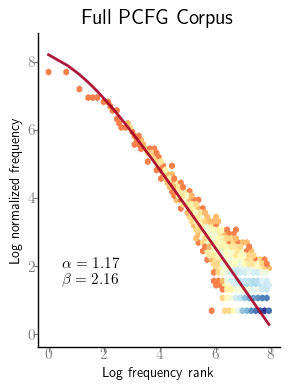

In [219]:
plot_Zipf_curve_comparison(AL, 'Full PCFG Corpus', cmap=newcmp, line_color=line_color)

## Shared levels

In [27]:
# read in shared_levels_PTB.txt
shared_levels_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/constprobing-repr/data/shared_levels_PTB.txt')
with open(shared_levels_path) as f:
	shared_levels = f.readlines()

cutoff_max = 20
cutoff_min = 6

skipped_idx = []
for i, sentence in enumerate(PTB):
	if len(sentence) >= cutoff_max or len(sentence) <= cutoff_min:
		skipped_idx.append(i)

shared_levels = [i for j, i in enumerate(shared_levels) if j not in skipped_idx]
shared_levelsPTB = [int(l.replace('\n', '')) for sentence in shared_levels for l in sentence.split(' ') if l != '\n']
len(shared_levelsPTB)

114021

In [28]:
shared_levels_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/constprobing-repr/data/train_shared_withoutROOT.txt')
with open(shared_levels_path) as f:
	shared_levels = f.readlines()

shared_levelsPCFG = [int(l.replace('\n', '')) for sentence in shared_levels for l in sentence.split(' ') if l != '\n']
len(shared_levelsPCFG)

105960

In [29]:
def stats_shared_levels(data, name):
	print(
		f"""
		{name:}
		The amount of labels is {len(data)}.
		There are {len(set(data))} unique labels.
		The labels are: {set(data)}.
		"""
	)

In [30]:
stats_shared_levels(shared_levelsPTB, name='PTB')
stats_shared_levels(shared_levelsPCFG, name='PCFG')


		PTB
		The amount of labels is 114021.
		There are 23 unique labels.
		The labels are: {0, 1, 2, 3, 4, 5, 6, 7, -15, -14, -13, -12, -11, -2, -9, -8, -7, -6, -5, -4, -3, -1, -10}.
		

		PCFG
		The amount of labels is 105960.
		There are 27 unique labels.
		The labels are: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1}.
		


In [36]:
def plot_shared_levels(datasets, names):
	plt.hist(datasets[0], density=True, alpha=0.7, label=names[0])

	ax = plt.gca()
	ax.spines[['right', 'top', 'left']].set_visible(False)
	ax.get_yaxis().set_visible(False) 

	plt.xlabel('Relative shared levels')
	plt.title('Relative shared levels of the PCFG')

	plt.savefig('plots/shared_levels_full.pdf')

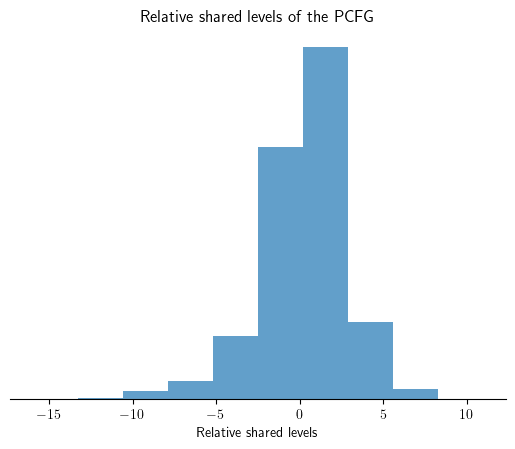

In [37]:
plot_shared_levels([shared_levelsPCFG], ['PCFG'])

## Chunking (distribution BIES labels)

In [1]:
bies_levels_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/constptbprobing/exp_chunk/train_bies_orig_simple.txt')
with open(bies_levels_path) as f:
	bies_labelsPTB = f.readlines()

bies_labelsPTB = [word.replace('\n', '') for sent in bies_labelsPTB for word in sent.split(' ')]
stats_shared_levels(bies_labelsPTB, name='PTB')


NameError: name 'Path' is not defined

In [11]:
bies_labels_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/constprobing-repr/data/train_bies_labels.txt')
with open(bies_labels_path) as f:
	bies_labelsPCFG = [word.replace('\n', '') for sent in f.readlines() for word in sent.split(' ')]
# stats_shared_levels(bies_labelsPCFG, name='PCFG')
Counter(bies_labelsPCFG)

Counter({'B': 47010, 'E': 27433, 'S': 24214, 'PCT': 17283, 'I': 20})

In [12]:
def bies_labels_comparison(dataPTB, dataPCFG):
	fig = plt.subplots(figsize =(8, 4)) 
	barWidth = 0.4

	# Set position of bar on X axis 
	br1 = np.arange(len(Counter(dataPTB))) 
	br2 = [x + barWidth for x in br1] 

	# Sort dictionaries on key
	dataPTB = dict(sorted(Counter(dataPTB).items()))
	dataPCFG = dict(sorted(Counter(dataPCFG).items()))
	
	# # Make the plot
	plt.bar(br1, Counter(dataPTB).values(), color ='#FF7F0E', alpha=0.9, width = barWidth, 
			label ='PTB') 
	plt.bar(br2, Counter(dataPCFG).values(), color ='#1F77B4', alpha=0.9, width = barWidth, 
			label ='PCFG') 
	
	# Add count labels above each bar
	for i, count in enumerate(Counter(dataPTB).values()):
		plt.text(br1[i], 2000, str(count), ha='center', color='white', size=8, weight='bold')

	for i, count in enumerate(Counter(dataPCFG).values()):
		if count <= 100:
				plt.text(br2[i], 2000, str(count), ha='center', color='black', size=8, weight='bold')
		else:
				plt.text(br2[i], 2000, str(count), ha='center', color='white', size=8, weight='bold')
	
	# Axis
	ax = plt.gca()
	ax.spines[['right', 'top', 'left']].set_visible(False)
	ax.tick_params(bottom=False, left=False)

	# Adding Xticks 
	plt.grid(axis='y', alpha=0.5)
	plt.xticks([r + (barWidth / 2) for r in range(len(Counter(dataPTB)))], 
			Counter(dataPTB).keys())
	plt.yticks(np.arange(0, 100000, 20000))

	plt.xlabel('BIES labels') 
	plt.ylabel('Frequency') 
	plt.title('BIES labels per dataset.')
	
	plt.legend()

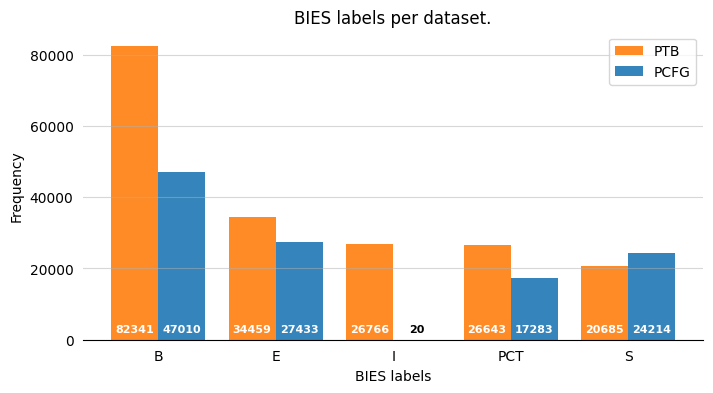

In [9]:
bies_labels_comparison(bies_labelsPTB, bies_labelsPCFG)

In [13]:
# read in shared_levels_PTB.txt
bies_levels_path = '/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/constprobing-repr/data/babyberta/normal'

bies_topk = {}
for topk in [0.2, 0.3, 0.4, 0.5]:
	current_path = f'{bies_levels_path}/{topk}/train_bies_labels.txt'
	with open(current_path) as f:
		bies_topk[topk] = Counter([word.replace('\n', '') for sent in f.readlines() for word in sent.split(' ')])

In [14]:
def bies_labels_topks(datatopks, dataPCFG, dataPTB):
	fig, axes = plt.subplots(2, 2) 

	topks = [0.2, 0.3, 0.4, 0.5]

	labels = ['B', 'I', 'E', 'S']
	x_labels = ['PTB', 'PCFG', '0.2', '0.3', '0.4', '0.5']

	flat = axes.flatten()
	dataPCFG = Counter(dataPCFG)
	dataPTB = Counter(dataPTB)
	label_keys = {}
	
	# for l in labels:
	#     label_keys[l] = [dataPTB[l], dataPCFG[l]]
	#     for topk in topks:
	# 		label_keys[l].append(datatopks[topk][l])

	# for i, ax in enumerate(axes.flatten()):
	#     temp_data = []


	#     barWidth = 0.4

	# Set position of bar on X axis 
	br1 = np.arange(len(Counter(dataPTB))) 
	br2 = [x + barWidth for x in br1] 

	# Sort dictionaries on key
	dataPTB = dict(sorted(Counter(dataPTB).items()))
	dataPCFG = dict(sorted(Counter(dataPCFG).items()))

	
	# # Make the plot
	plt.bar(br1, Counter(dataPTB).values(), color ='#FF7F0E', alpha=0.9, width = barWidth, 
			label ='PTB') 
	plt.bar(br2, Counter(dataPCFG).values(), color ='#1F77B4', alpha=0.9, width = barWidth, 
			label ='PCFG') 
	
	# Add count labels above each bar
	for i, count in enumerate(Counter(dataPTB).values()):
		plt.text(br1[i], 2000, str(count), ha='center', color='white', size=8, weight='bold')

	for i, count in enumerate(Counter(dataPCFG).values()):
		if count <= 100:
				plt.text(br2[i], 2000, str(count), ha='center', color='black', size=8, weight='bold')
		else:
				plt.text(br2[i], 2000, str(count), ha='center', color='white', size=8, weight='bold')
	
	# Axis
	ax = plt.gca()
	ax.spines[['right', 'top', 'left']].set_visible(False)
	ax.tick_params(bottom=False, left=False)
	axes.flat[-1].set_visible(False)

	# Adding Xticks 
	plt.grid(axis='y', alpha=0.5)
	plt.xticks([r + (barWidth / 2) for r in range(len(Counter(dataPTB)))], 
			Counter(dataPTB).keys())
	plt.yticks(np.arange(0, 100000, 20000))

	plt.xlabel('BIES labels') 
	plt.ylabel('Frequency') 
	plt.title('BIES labels per dataset.')
	
	plt.legend()

In [21]:
def bies_labels_topks(data_topks, dataPCFG):
	fig, axes = plt.subplots(2, 2, sharey=True)
	topks = [0.2, 0.3, 0.4, 0.5]

	per_label = {}
	for label in ['B', 'I', 'E', 'S']:
		per_label[label] = {}
		# per_label[label]['PTB'] = Counter(dataPTB)[label]
		per_label[label]['PCFG'] = Counter(dataPCFG)[label]

		for topk in topks:
			per_label[label][str(topk)] = data_topks[topk][label]
	
	flat = axes.flatten()
	for idx, (l, data) in enumerate(per_label.items()):
		ax = flat[idx]

		ax.bar(data.keys(), data.values(), color=['#8FBBD9', '#8FBBD9', '#1F77B4', '#1F77B4', '#1F77B4', '#1F77B4'])
		ax.set_title(f'Label:{l}')

		ax.spines[['right', 'top', 'left']].set_visible(False)
		ax.get_yaxis().set_visible(False) 
		
	plt.suptitle('BIES Labels per Corpus')
	plt.tight_layout()

	plt.savefig('plots/bies_labels_topks.pdf')

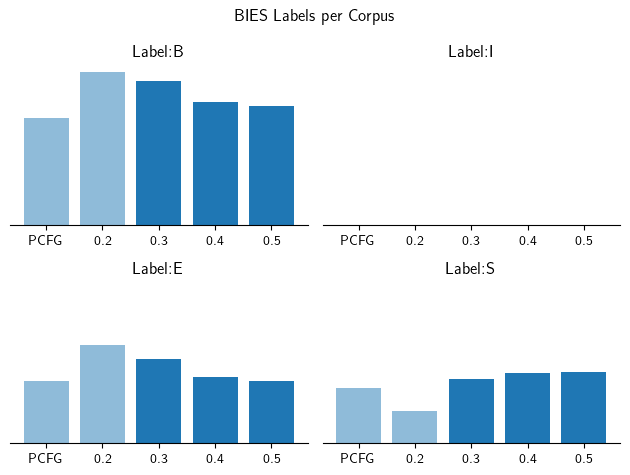

In [22]:
bies_labels_topks(bies_topk, bies_labelsPCFG)

## LCA labels

In [145]:
lca_topk = {'0.2': {'VP': 0,
		 'ATS': 0,
		 'S': 0,
		 'NP': 0,
		 'ATVP': 0,
		 'PP': 0,
		 'ATNP': 0,
		 'SBAR': 0,
		 'ADJP': 0,
		 'ATADJP': 0}, 
		 '0.3': {'VP': 0,
		 'ATS': 0,
		 'S': 0,
		 'NP': 0,
		 'ATVP': 0,
		 'PP': 0,
		 'ATNP': 0,
		 'SBAR': 0,
		 'ADJP': 0,
		 'ATADJP': 0}, 
		 '0.4': {'VP': 0,
		 'ATS': 0,
		 'S': 0,
		 'NP': 0,
		 'ATVP': 0,
		 'PP': 0,
		 'ATNP': 0,
		 'SBAR': 0,
		 'ADJP': 0,
		 'ATADJP': 0}, 
		 '0.5': {'VP': 0,
		 'ATS': 0,
		 'S': 0,
		 'NP': 0,
		 'ATVP': 0,
		 'PP': 0,
		 'ATNP': 0,
		 'SBAR': 0,
		 'ADJP': 0,
		 'ATADJP': 0}}

In [146]:
lca_path = '/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/constprobing-repr/data/babyberta/normal'


for topk in [0.2, 0.3, 0.4, 0.5]:
	current_path = f'{lca_path}/{topk}/train_rel_labels.txt'
	with open(current_path) as f:
		data = Counter([word.replace('\n', '') for sent in f.readlines() for word in sent.split(' ')])
		for label in data.keys():
			lca_topk[str(topk)][label] = data[label]

In [149]:
def plot_lca_topk(lca_topk):
	# Prepare data for plotting
	categories = list(lca_topk['0.2'].keys())
	x = np.arange(len(categories))  # the label locations
	width = 0.2  # the width of the bars

	# Create subplots
	fig, ax = plt.subplots()

	# Define offsets for each group
	offsets = [-1.5 * width, -0.5 * width, 0.5 * width, 1.5 * width]

	# Plot each set of bars
	
	colors = ['#1F77B4', '#8FBBD9', '#FF7F0E', '#FFBF86']

	for i, (key, data) in enumerate(lca_topk.items()):
		values = list(data.values())
		ax.bar(x + offsets[i], values, width, label=key, color=colors[i])

	# Add labels, title, and custom x-axis tick labels, etc.
	ax.set_xlabel('LCA labels')
	ax.set_title('Distribution of LCA labels per grammar subset')
	ax.set_xticks(x)
	ax.set_xticklabels(categories)
	ax.legend(title='Subset')

	ax.spines[['right', 'top', 'left']].set_visible(False)
	ax.get_yaxis().set_visible(False) 

	# Show plot
	plt.xticks(rotation=45)
	plt.tight_layout()
	
	plt.savefig('plots/lca_topk.pdf')

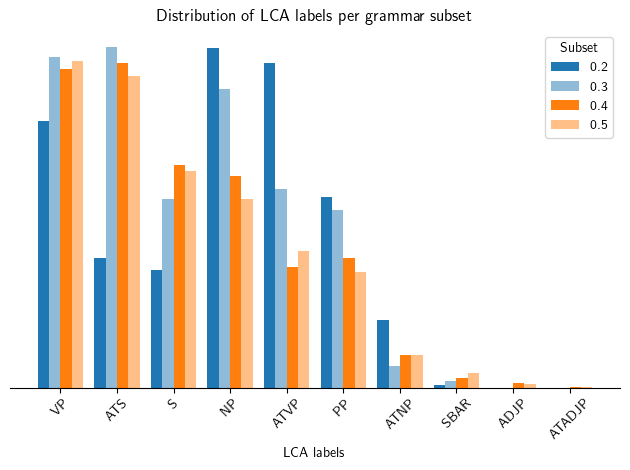

In [150]:
plot_lca_topk(lca_topk)

In [124]:
lca_levels_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/constptbprobing/exp_lca/train_lca_orig_rel_labels.txt')
with open(lca_levels_path) as f:
	lca_labelsPTB = f.readlines()

lca_labelsPTB = [word.replace('\n', '') for sent in lca_labelsPTB for word in sent.split(' ')]
stats_shared_levels(lca_labelsPTB, name='PTB')


		PTB
		The amount of labels is 10328399.
		There are 29 unique labels.
		The labels are: {'', 'NP', 'ADJP', 'ADVP', 'WHADVP', 'PP', 'RRC', 'PRT|ADVP', 'SBAR', 'NAC', 'FRAG', 'UCP', 'VP', 'LST', 'WHADJP', 'CONJP', 'SBARQ', 'PRN', 'X', 'PRT', 'QP', 'ADVP|PRT', 'NX', 'SQ', 'WHPP', 'S', 'WHNP', 'INTJ', 'SINV'}.
		


In [125]:
lca_sampled_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/constptbprobing/exp_lca/train_lca_orig_rel_labels_sampled.txt')
with open(lca_sampled_path) as f:
	lca_sampledPTB = f.readlines()

lca_sampledPTB = [word.replace('\n', '') for sent in lca_sampledPTB for word in sent.split(' ')]
stats_shared_levels(lca_sampledPTB, name='PTB')


		PTB
		The amount of labels is 44958.
		There are 28 unique labels.
		The labels are: {'NP', 'ADVP', 'WHADVP', 'ADJP', 'PP', 'RRC', 'PRT|ADVP', 'SBAR', 'NAC', 'FRAG', 'UCP', 'VP', 'LST', 'WHADJP', 'CONJP', 'SBARQ', 'PRN', 'X', 'PRT', 'QP', 'ADVP|PRT', 'NX', 'SQ', 'WHPP', 'S', 'WHNP', 'INTJ', 'SINV'}.
		


In [126]:
lca_PCFG_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/constprobing-repr/data/train_rel_labels.txt')
with open(lca_PCFG_path) as f:
	lca_PCFG = f.readlines()

lca_PCFG = [word.replace('\n', '') for sent in lca_PCFG for word in sent.split(' ')]
stats_shared_levels(lca_PCFG, name='PCFG')


		PCFG
		The amount of labels is 105960.
		There are 43 unique labels.
		The labels are: {'NP', 'ADJP', 'ADVP', 'ATPRN', 'WHADVP', 'ATVP', 'ATSBAR', 'ATPRT', 'PP', 'RRC', 'SBAR', 'ATSBARQ', 'NAC', 'ATUCP', 'ATSINV', 'ATCONJP', 'FRAG', 'ATWHNP', 'ATFRAG', 'UCP', 'ATADVP', 'ATSQ', 'VP', 'WHADJP', 'CONJP', 'SBARQ', 'ATQP', 'PRN', 'X', 'PRT', 'QP', 'ATPP', 'NX', 'SQ', 'WHPP', 'ATINTJ', 'S', 'ATADJP', 'ATS', 'ATNP', 'WHNP', 'INTJ', 'SINV'}.
		


In [134]:
def plot_lca(dataset, name):
	plt.figure(figsize=(12, 4))

	# sort counter of dataset by value
	dataset = dict(sorted(Counter(dataset).items(), key=lambda item: item[1], reverse=True))
	plt.bar(*zip(*dataset.items()), alpha=0.9)

	ax = plt.gca()
	ax.spines[['right', 'top', 'left']].set_visible(False)
	ax.tick_params(bottom=False, left=False)

	# Rotate x-axis labels
	plt.xticks(rotation=45)
	plt.grid(axis='y', alpha=0.5)


	plt.xlabel('Lowest common ancestor (LCA) label')
	plt.title(f'Distribution of LCA labels of {name} corpus')
	
	plt.tight_layout()
	plt.savefig(f'plots/lca_dist_{name}.pdf')

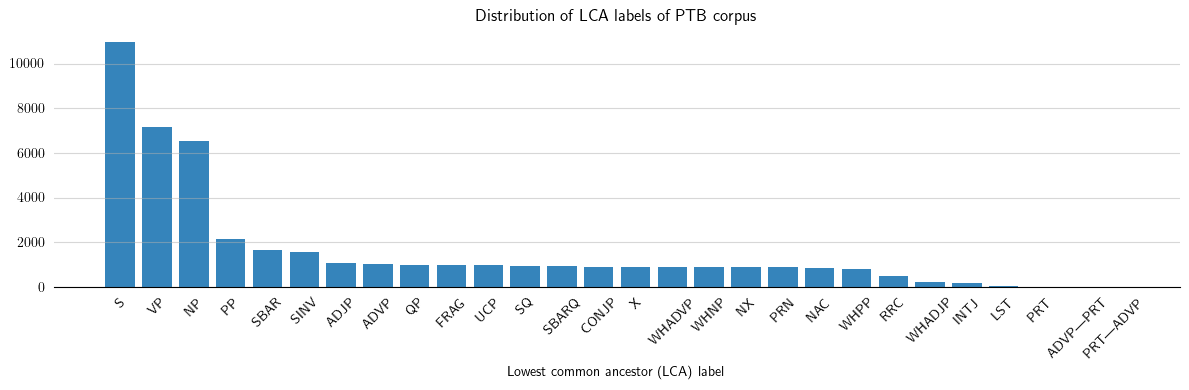

In [135]:
plot_lca(lca_sampledPTB, 'PTB')

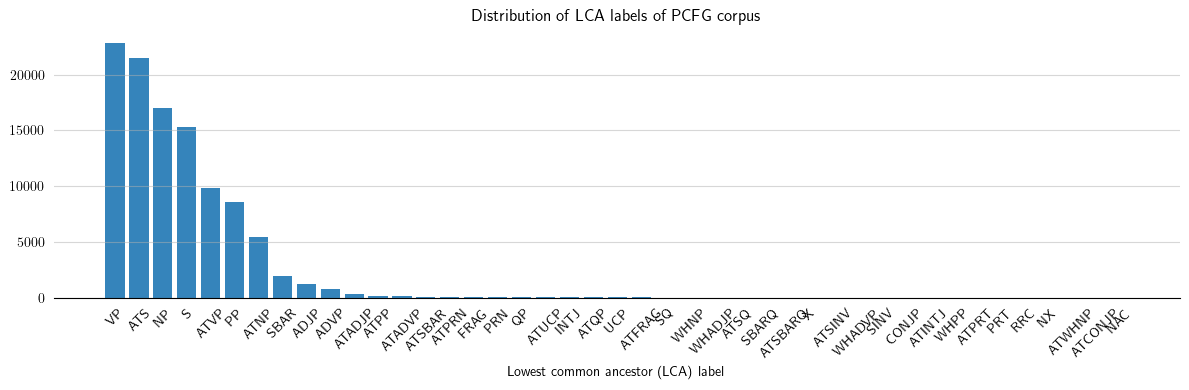

In [136]:
plot_lca(lca_PCFG, 'PCFG')

In [48]:
def func(x, a, b):
	return np.log(1/((x + b)**a))

/var/folders/4j/29pdgy4j4cx8q11l89q0hpch0000gn/T/ipykernel_28571/3982058154.py:1: RuntimeWarning: divide by zero encountered in log
  x_values = np.log(np.arange(0, 100))
/var/folders/4j/29pdgy4j4cx8q11l89q0hpch0000gn/T/ipykernel_28571/1972983957.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(1/((x + b)**a))


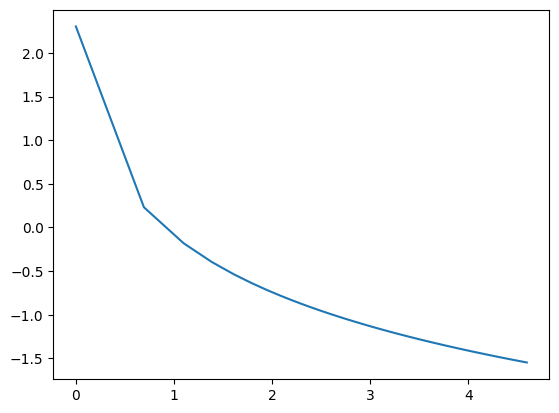

In [54]:
x_values = np.log(np.arange(0, 100))
y_values = func(x_values, 1, 0.1)

plt.plot(x_values, y_values)

# For top k grammars

## Shared levels

In [151]:
def plot_shared_levels_overlaying(data):
	fig, ax = plt.subplots(1, 1, figsize=(8, 8))

	topks = [0.2, 0.3, 0.4, 0.5]
	for i, topk in enumerate(topks):
		ax.hist(data[topks[i]], alpha=0.7)

		ax.spines[['right', 'top', 'left']].set_visible(False)
		ax.get_yaxis().set_visible(False) 

		ax.set_title(f'Top k: {topks[i]}')

	# fig.supxlabel('$\emph{log} \: P_{LM}(w)$', fontsize=16)
	# fig.supylabel('$\emph{log} \: P_{PCFG}(w)$', fontsize=16)
	fig.suptitle(f'Correlation between the LM and PCFG probabilities', fontsize=18)

	plt.tight_layout()

In [165]:
def plot_shared_levels(data, og):
	fig, axes = plt.subplots(2, 2, figsize=(8, 8))

	topks = [0.2, 0.3, 0.4, 0.5]
	for i, ax in enumerate(axes.flatten()):
		ax.hist(og, alpha=0.3, color='#1F77B4')
		ax.hist(data[topks[i]], alpha=0.7, color='#FF7F0E')
 

		ax.spines[['right', 'top', 'left']].set_visible(False)
		ax.get_yaxis().set_visible(False) 

		ax.set_title(f'Subset: {topks[i]}')

		ax.set_xlim(-15, )

	# topks = [0.2, 0.3, 0.4, 0.5]
	# for i, topk in enumerate(topks):
	#     ax.hist(data[topks[i]], bins=20, alpha=0.7)

	#     ax.spines[['right', 'top', 'left']].set_visible(False)
	#     ax.get_yaxis().set_visible(False) 

	#     ax.set_title(f'Top k: {topks[i]}')

	fig.supxlabel('Relative shared level', fontsize=12)
	# fig.supylabel('$\emph{log} \: P_{PCFG}(w)$', fontsize=16)
	fig.suptitle(f'Relative shared levels for pruned grammars', fontsize=18)

	plt.tight_layout()
	plt.savefig('plots/shared_levels_topks.pdf')

In [166]:
# read in shared_levels_PTB.txt
shared_levels_path = '/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/constprobing-repr/data/babyberta/normal'

rel_levels_topk = {}
for topk in [0.2, 0.3, 0.4, 0.5]:
	current_path = f'{shared_levels_path}/{topk}/train_shared_levels.txt'
	with open(current_path) as f:
		data = f.readlines()
		data = [l.replace('\n', '') for sentence in data for l in sentence.split(' ') if l != '\n']
		rel_levels_topk[topk] = [int(l) for l in data if l != 'ROOT']

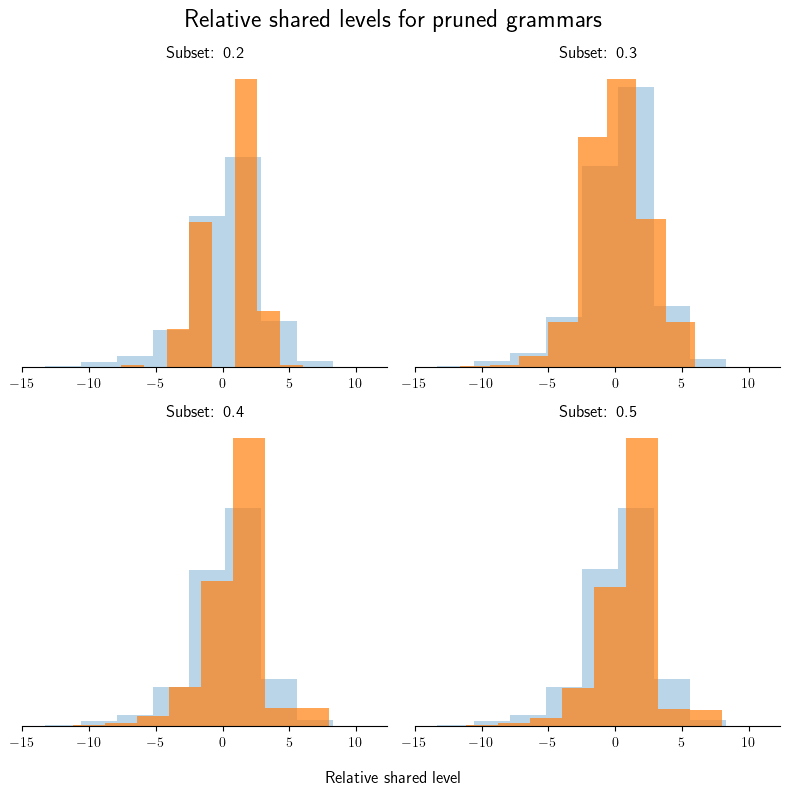

In [167]:
plot_shared_levels(rel_levels_topk, shared_levelsPCFG)

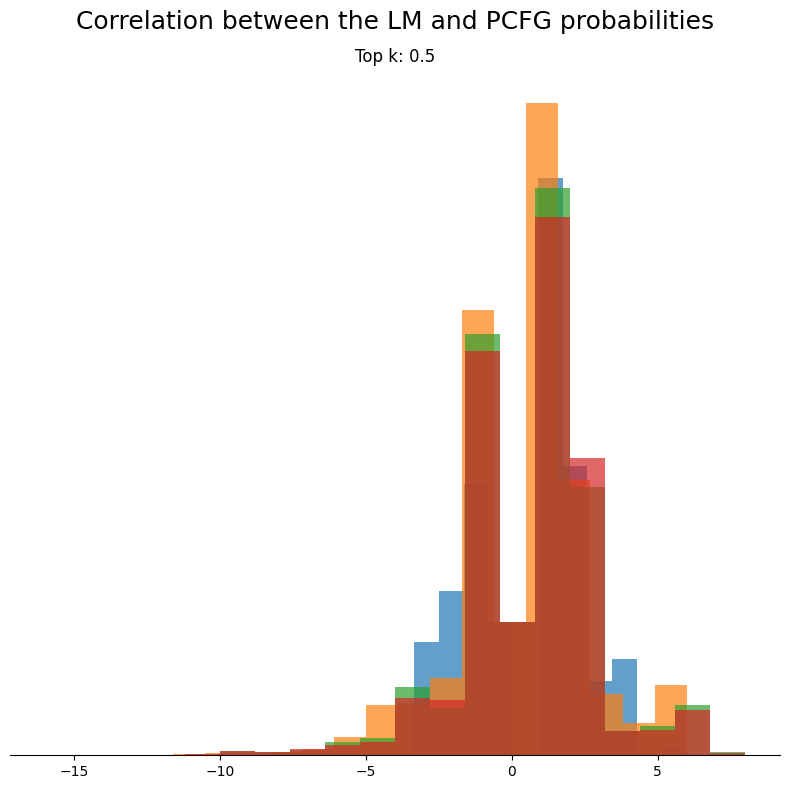

In [110]:
plot_shared_levels_overlaying(rel_levels_topk)